In [23]:
%matplotlib inline
import openmc
openmc.config['cross_sections'] = '/home/openmc/endfb-vii.1-hdf5/cross_sections.xml'


In [24]:
# Materials definitions

fuel = openmc.Material(name='Fuel')
fuel.add_element('U', 1.0, enrichment=17.0)
fuel.add_nuclide('O16', 2.0)
fuel.set_density('g/cm3', 10.41)

buffer = openmc.Material(name='Buffer')
buffer.add_element("C", 1.0)
buffer.set_density('g/cm3', 1.1)
buffer.add_s_alpha_beta('c_Graphite')

IPyC = openmc.Material(name='Inner PyC')
IPyC.add_element("C", 0.5)
IPyC.set_density('g/cm3', 1.9)
IPyC.add_s_alpha_beta('c_Graphite')

SiC = openmc.Material(name = "SiC")
SiC.add_element("Si", 0.5)
SiC.add_element("C", 1.0)
SiC.set_density("g/cm3", 3.18)

OPyC = openmc.Material(name='Outer PyC')
OPyC.add_element("C", 1.0)
OPyC.set_density('g/cm3', 1.9)
OPyC.add_s_alpha_beta('c_Graphite')

graphite = openmc.Material(name='Graphite')
graphite.add_element("C", 1.0)
graphite.set_density('g/cm3', 1.73)


helium = openmc.Material(name='Helium')
helium.add_element('He', 1.0)
helium.set_density('g/cm3', 1.149e-3)

b4c = openmc.Material(name='B4C Poison')
b4c.add_element('B', 4.0, enrichment=18.7, enrichment_target='B10', enrichment_type='wo')
b4c.add_element("C", 1.0)
b4c.set_density('g/cm3', 1.82)

# Instantiate a Materials collection and export to xml
materials_list = [fuel, buffer, IPyC, SiC, OPyC, graphite, helium, b4c]
materials_file = openmc.Materials(materials_list)
materials_file.export_to_xml()

/home/openmc/miniconda3/envs/openmc-env/lib/python3.11/site-packages/openmc/material.py:825: UserWarning: A uranium enrichment of 17.0 was given for Material ID="9". OpenMC assumes the U234/U235 mass ratio is constant at 0.008, which is only valid at low enrichments. Consider setting the isotopic composition manually for enrichments over 5%.
  warnings.warn(msg)


<Axes: xlabel='x [cm]', ylabel='y [cm]'>

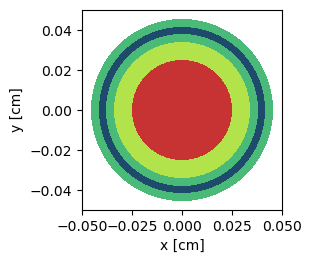

In [25]:
# Geometry definitions for TRISO particles
r1 = openmc.Sphere(r=250e-4)
r2 = openmc.Sphere(r=340e-4)
r3 = openmc.Sphere(r=380e-4)
r4 = openmc.Sphere(r=415e-4)
r5 = openmc.Sphere(r=455e-4)

layers = [r1, r2, r3, r4, r5]
triso_mats = [fuel, buffer, IPyC, SiC, OPyC]
triso_cells = [
    openmc.Cell(fill=fuel, region=-r1),
    openmc.Cell(fill=buffer, region=+r1 & -r2),
    openmc.Cell(fill=IPyC, region=+r2 & -r3),
    openmc.Cell(fill=SiC, region=+r3 & -r4),
    openmc.Cell(fill=OPyC, region=+r4 & -r5),]

triso_universe = openmc.Universe(cells=triso_cells)
triso_colors = {triso_cells[0]: (199, 51, 51), triso_cells[1]: (178, 227, 74), 
                triso_cells[2]: (74, 186, 120), triso_cells[3]: (30, 74, 107), 
                triso_cells[4]: (74, 186, 120)}
triso_universe.plot(width = (0.1, 0.1), colors = triso_colors)

In [26]:
print(triso_cells)


[Cell
	ID             =	142521
	Name           =	
	Fill           =	Material 9
	Region         =	-134304
	Rotation       =	None
	Temperature    =	None
	Density        =	None
	Translation    =	None
	Volume         =	None
, Cell
	ID             =	142522
	Name           =	
	Fill           =	Material 10
	Region         =	(134304 -134305)
	Rotation       =	None
	Temperature    =	None
	Density        =	None
	Translation    =	None
	Volume         =	None
, Cell
	ID             =	142523
	Name           =	
	Fill           =	Material 11
	Region         =	(134305 -134306)
	Rotation       =	None
	Temperature    =	None
	Density        =	None
	Translation    =	None
	Volume         =	None
, Cell
	ID             =	142524
	Name           =	
	Fill           =	Material 12
	Region         =	(134306 -134307)
	Rotation       =	None
	Temperature    =	None
	Density        =	None
	Translation    =	None
	Volume         =	None
, Cell
	ID             =	142525
	Name           =	
	Fill           =	Material 13
	Regio

In [27]:
pebble_radius = 3.0  # cm
shell_thickness = 0.5  # 5 mm = 0.5 cm

fuel_zone_radius = pebble_radius - shell_thickness

# Surfaces
pebble_surf = openmc.Sphere(r=pebble_radius)
fuel_zone_surf = openmc.Sphere(r=fuel_zone_radius)
fuel_zone_region = -fuel_zone_surf
shell_region = +fuel_zone_surf & -pebble_surf
triso_outer_radius = 455e-4  # cm
#packing des triso
spheres = openmc.model.pack_spheres(
    radius=triso_outer_radius,
    region=fuel_zone_region,
    pf=0.30
)

In [6]:
triso_particles = [openmc.model.TRISO(triso_outer_radius,fill=triso_universe,center=c) for c in spheres]

In [7]:
vol_triso = 4/3 * 3.14 * triso_outer_radius **3 * len(triso_particles)
actual_pf= vol_triso/(4/3 * 3.14 * fuel_zone_radius**3)
print(actual_pf)

0.29999962938399993


In [8]:
pebble_cell = openmc.Cell(region=fuel_zone_region)
lower_left, upper_right = pebble_cell.region.bounding_box

shape = (6, 6, 6)  # finesse spatiale
pitch = (upper_right - lower_left) / shape

triso_lattice = openmc.model.create_triso_lattice(triso_particles,lower_left,pitch,shape,graphite)

pebble_cell.fill = triso_lattice
shell_cell = openmc.Cell(fill=graphite,region=shell_region)

lattice_universe = openmc.Universe(cells=[pebble_cell, shell_cell])

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

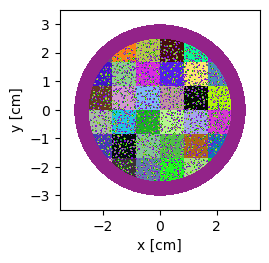

In [9]:
lattice_universe.plot(width=(7,7))

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

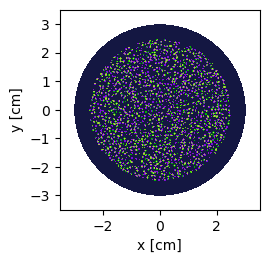

In [10]:
lattice_universe.plot(width=(7,7), color_by='material', colors = {graphite: (20, 23, 66)})

In [11]:
outside_region = +fuel_zone_surf 
outside_cell = openmc.Cell(fill=helium,region=outside_region)
pebble_universe = openmc.Universe(cells=[pebble_cell, shell_cell, outside_cell])


<Axes: xlabel='x [cm]', ylabel='y [cm]'>

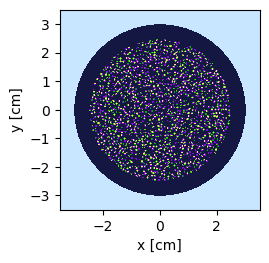

In [12]:
pebble_universe.plot(width=(7,7),color_by="material",colors={graphite: (20, 23, 66),fuel: (255, 219, 145),helium: (200, 230, 255)})


In [13]:
#Définir le volume du cœur (où les pebbles vivent) cylindre
core_radius = 30.0  # cm

core_sph= openmc.Sphere(r=core_radius,boundary_type='reflective')
core_region = -core_sph




In [14]:
#Packing des pebbles
centers = openmc.model.pack_spheres(radius=pebble_radius,region=core_region,pf=0.61)
print(f"Nombre de pebbles générés : {len(centers)}")

pebbles = [openmc.model.TRISO(pebble_radius,fill=pebble_universe,center=c)for c in centers]

Nombre de pebbles générés : 610


/home/openmc/miniconda3/envs/openmc-env/lib/python3.11/site-packages/openmc/model/triso.py:1188: UserWarning: Close random pack converged before reaching true sphere radius; some spheres may overlap. Try reducing contraction rate or packing fraction.
  warnings.warn('Close random pack converged before reaching true '


In [15]:
reflector_outer = openmc.Sphere(r=35.0)

reflector_cell = openmc.Cell(
    fill=graphite,
    region=+core_sph & -reflector_outer
)


In [16]:
# -----------------------------
# CONTROL ROD (POISON BAR)
# -----------------------------

poison_radius = 1.5   # plus réaliste pour petit cœur
poison_height = 80.0  # > diamètre cœur (60 cm)


poison_cyl = openmc.ZCylinder(r=poison_radius)
poison_top = openmc.ZPlane(z0=poison_height/2)
poison_bot = openmc.ZPlane(z0=-poison_height/2)

poison_region = (
    -poison_cyl
    & -poison_top
    & +poison_bot
    & -core_sph
)
poison_cell = openmc.Cell(
    fill=b4c,
    region=poison_region
)



In [17]:
#Gaine graphite autour de la barre
clad_radius = 2.0  # légèrement > poison_radius

clad_cyl = openmc.ZCylinder(r=clad_radius)

clad_region = (
    -clad_cyl
    & +poison_cyl
    & -poison_top
    & +poison_bot
    & -core_sph
)

clad_cell = openmc.Cell(
    fill=graphite,
    region=clad_region
)


In [18]:
bed_cell = openmc.Cell(region=core_region & ~poison_region & ~clad_region)

lower_left, upper_right = bed_cell.region.bounding_box

shape = (20, 20, 20)  # résolution spatiale
pitch = (upper_right - lower_left) / shape

bed_lattice = openmc.model.create_triso_lattice(
    pebbles,
    lower_left,
    pitch,
    shape,
    background=helium
)

bed_cell.fill = bed_lattice


In [19]:
core_universe = openmc.Universe(
    cells=[bed_cell,poison_cell,clad_cell,reflector_cell])



geometry = openmc.Geometry(core_universe)
geometry.export_to_xml()


<Axes: xlabel='x [cm]', ylabel='y [cm]'>

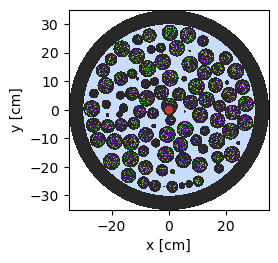

In [20]:
#Plot léger (pixels reduit)
core_universe.plot(
    basis="xy",
    width=(70, 70),
    color_by="material",
    colors={
        b4c: (200, 50, 50),
        graphite: (40, 40, 40),
        helium: (200, 220, 255)
    }
)


In [21]:
# OpenMC simulation parameters

batches = 100
inactive = 10
particles = 5000

settings_file = openmc.Settings()
settings_file.batches = batches
settings_file.inactive = inactive
settings_file.particles = particles
settings_file.output = {'tallies': True}

source = openmc.IndependentSource()
source.space = openmc.stats.Point((0.0, 0.0, 0.0))

settings_file.source = source


settings_file.export_to_xml()

In [22]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################